## import

In [1]:
import pandas as pd
import math as m
import numpy as np
from os import listdir, mkdir
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import time
from PIL import Image
from statannot import add_stat_annotation
import matplotlib
import scipy.stats as sps

pix_to_micron = 0.1559814453125*2 #conversion factor
threshold = 500 #distance to the interhemisphere in microns 

def initialisation(path_to_folder, name_extraction):
    path_name = path_to_folder+"\\"+name_extraction+"\extraction_data"
    mkdir(path_to_folder+"\\"+name_extraction)
    mkdir(path_name)
    folders_name = ["calibration", "coordinates", "distance", "volume", "intensity"]
    for folder in folders_name:
        mkdir(path_name+"\\"+folder)

def extract():
    distance_csv = listdir(path_to_folder + "\distance")
    try:
        mkdir(path_to_folder+"\\"+name_extraction)
    except: pass
    for csv in distance_csv:
        
        name = csv.split('-')[0]
        print(name)
        data  = pd.read_csv(path_to_folder + "\\distance\\"+csv)
        coords = pd.read_csv(path_to_folder + "\\coordinates\\"+name+'-centroid.csv')

        df = pd.merge(data, coords, on='Label')

        #scaling coordinates of extremum of the line
        df['P1x'] = df['P1x']/2
        df['P1y'] = df['P1y']/2
        df['P2x'] = df['P2x']/2
        df['P2y'] = df['P2y']/2
        #storing coordinates of extremum of the line
        x1 = df.loc[1,'P1x']
        y1 = df.loc[1,'P1y']
        x2 = df.loc[1,'P2x']
        y2 = df.loc[1,'P2y']
       
        ymin = min(y1, y2) 
        ymax = y1+y2-ymin
        
        #keeping the cells on the right side of the segment.
        if df.iloc[1]['side']==2:
            df_distance = df.loc[df['pos']==-1.0].copy()
        else :
            df_distance = df.loc[df['pos']==1.0].copy()

        df_distance['distUnit'] = df_distance['distPix']*pix_to_micron

        #removing the cells outside the region of insterest
        df_distance = df_distance.drop(df_distance[df_distance['distUnit']>500].index)
        df_distance = df_distance.drop(df_distance[df_distance['Cy_Pix']<ymin].index)
        df_distance = df_distance.drop(df_distance[df_distance['Cy_Pix']>ymax].index)
        
        #area calculation
        df_distance['area'] = df_distance['length']*pix_to_micron*500
        n = len(df_distance)
        df_distance['density/100sqmicron'] = 100*n/df_distance['area']

        df_volume =  pd.read_csv(path_to_folder + "\\volume\\"+name+'-volumeReelin.csv')

        df3 = df_distance.merge(df_volume, on = 'Label', how = 'left')

        df_intensity = pd.read_csv(path_to_folder + "\\intensity\\"+name+'-quantifReelin.csv')
        df_intensity=df_intensity.drop(columns=['imageLabel'])
        df_final = df3.merge(df_intensity, on = 'Label', how = 'left')
        df_final = df_final.drop(columns=['imageLabel', 'imageSignal', 'imageLabel_y','pos', 'segment'])

        df_final.to_csv(path_to_folder+"\\"+ name_extraction +"\\%s.csv"%name)
        

    path_to_results = path_to_folder+"\\"+ name_extraction+"\\"
    analysed_csv = listdir(path_to_results)
    list_df = []
    for i, csv in enumerate(analysed_csv):
        infos = csv.split('_')
        results = pd.read_csv(path_to_results +csv)
        results["ID"]=infos[1]+infos[2]+infos[3]
        results["Condition"]=infos[3]
        results["Sex"]=infos[5]
        results["Bregma_coord"]=infos[9].replace('FIG', '')
        
        list_df.append(results)

    datafff = pd.concat(list_df)
    
    #bins = [50*i for i in range(12)]
    bins = [0, 120, 270, 500]

    datafff['bins'] = pd.cut(datafff['distUnit'], bins)
 
    timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
    

    datafff.rename(columns={"Mean": "mean_intensity", "Min" : "min_intensity", "Max" : "max_intensity", "StdDev" : "intensity_sd", "Sum": "voxel_intensity_sum"}, inplace=True)
    datafff.to_csv(path_to_folder+"\\extraction_"+timestr+".csv")



def extract_sex(df): #returns a dataframe for each sex
    males = df.loc[df['Sex']=='M'].copy()
    females = df.loc[df['Sex']=='F'].copy()
    return males, females


def extract_conditions(df): #returns a dataframe for each condition
    naive = df.loc[df['Condition']=='Naive'].copy()
    #veh = df.loc[df['Condition']=='Veh'].copy()
    srwin = df.loc[df['Condition']=='SRWin'].copy()
    win = df.loc[df['Condition']=='Win'].copy()

    return naive, srwin, win


def extract_Bregma_coords(df): #returns a dataframe for each Bregma_coord
    fig9 =  df.loc[df['Bregma_coord']==9].copy()
    fig10 =  df.loc[df['Bregma_coord']==10].copy()
    fig11 =  df.loc[df['Bregma_coord']==11].copy()
    fig12 =  df.loc[df['Bregma_coord']==12].copy()
    fig13 =  df.loc[df['Bregma_coord']==13].copy()
    fig14 =  df.loc[df['Bregma_coord']==14].copy()
    fig15 =  df.loc[df['Bregma_coord']==15].copy()

    return fig9, fig10, fig11, fig12, fig13, fig14, fig15


def distribution_plot(df): 
    sns.displot(df, x="distUnit", hue="Condition", kind="kde", multiple="stack", common_norm=False, bw_adjust=0.4)
    plt.show()


def displot_3D(df, title): #create a 3D plot of cell density / distance to the line and along Bregma_coords
    kde = gaussian_kde([df['distUnit'], df['Bregma_coord']], bw_method=0.3)
    x_grid, y_grid = np.meshgrid(np.linspace(df['distUnit'].min(), df['distUnit'].max(), 100),
                                np.linspace(df['Bregma_coord'].min(), df['Bregma_coord'].max(), 100))
    z = np.reshape(kde([x_grid.flatten(), y_grid.flatten()]), x_grid.shape)
    fig = go.Bregma_coord(data=[go.Surface(z=z, x=x_grid, y=y_grid)])
    fig.update_layout(scene=dict(xaxis_title='Distance (µm)', yaxis_title='Bregma_coord', zaxis_title='Density'), title=title)
    fig.show()


colors = ['#000000','#FC8608','#0379F7']
customPalette = sns.set_palette(sns.color_palette(colors))

def letter_annotation(ax, xoffset, yoffset, letter):
        ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
                size=12, weight='bold')

def custom_boxplot(data, x, y, ax, letter='', palette = customPalette, title = None, xlabel = None, ylabel = None, stat = True , pairs =[("Naive", "Win"), ("SRWin", "Naive"), ("SRWin", "Win")]):

        
    plot = sns.boxplot(data=data, 
                            x=x, 
                            y = y,
                            showfliers = False, 
                            width=0.4, 
                            palette=palette,
                            ax=ax,)
    sns.stripplot(data = data, 
                x = x,
                y = y,
                palette=sns.color_palette(),
                alpha = 0.3,
                ax=ax)
    ax.set(title = title, xlabel = xlabel, ylabel = ylabel)
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
        box_patches = ax.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
    if stat:
        add_stat_annotation(plot, data=data, x=x, y=y, 
                            comparisons_correction = None,
                            box_pairs=pairs,
                            test='Mann-Whitney', 
                            text_format='star', 
                            loc='inside', 
                            verbose=2)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['bottom'].set_color('black')

    ax.spines['left'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    sns.set_style("ticks")
    letter_annotation(ax, -0.09, 1.05, letter)


## data

In [2]:
df = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\allcells.csv")
df.rename(columns={"Mean": "mean_intensity", "Min" : "min_intensity", "Max" : "max_intensity", "StdDev" : "intensity_sd", "Sum": "voxel_intensity_sum", "Figure": "Bregma_coord"}, inplace=True)
bregma_coord = {9: 2.58, 10: 2.46, 11: 2.34, 12: 2.22, 13: 2.10, 14:1.98, 15:1.94, 16:1.78}
df['Bregma_coord'].replace(bregma_coord, inplace=True)

#remove bad mice
df= df.drop(df[df['ID'] == 'B5Mouse0Win'].index)
df= df.drop(df[df['ID'] ==  'B5Mouse2Win'].index)
df= df.drop(df[df['ID'] == 'B4PPGI1Naive'].index)
df= df.drop(df[df['ID'] == 'B5Mouse4Veh'].index)
#df= df.drop(df[df['ID'] == 'B2Mouse2Veh'].index) prendre que fig 10 12
df= df.drop(df[df['ID'] == 'B5Mouse5Naive'].index)
#df= df.drop(df[df['ID'] == 'B2Mouse3Win'].index) pas fig16



height = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\height.csv").reset_index()

df = pd.merge(df, height, on = 'imageLabel_x')

df['volumic_density'] = df['density/100sqmicron']/df['Height']
df['volumic_density'] = df['density/100sqmicron']/df['Height']
naive, srwin, win = extract_conditions(df)

cytoplasmic = df.loc[df['max_intensity']>150].copy()


df_categ = df

df_categ['Condition'] = pd.Categorical(df_categ['Condition'], categories = ['Naive', 'Win', 'SRWin'], ordered=True)

mean_animal = {'Naive' : [], 'Win' : [], 'SRWin' : []}
for temp in (pd.unique(df_categ['Condition'])):
    print(temp)
    mean_animal[temp] = df_categ[df_categ['Condition']==temp].groupby('ID').mean()

mean_animal['Win']['Condition']= 'Win'
mean_animal['Naive']['Condition']= 'Naive'
mean_animal['SRWin']['Condition']= 'SRWin'
mean_animal = pd.concat([mean_animal['Naive'],mean_animal['Win'], mean_animal['SRWin']])
mean_animal['Volume_Unit']=mean_animal['Volume_Pix']*(pix_to_micron**3)

bin_count = {'Naive' : [], 'Win' : [], 'SRWin' : []}
df_categ = df_categ[df_categ['max_intensity']>150]
for temp in (pd.unique(df_categ['Condition'])):
    print(temp)
    bin_count[temp] = pd.DataFrame(df_categ[df_categ['Condition']==temp].groupby(['imageLabel_x','ID', 'Bregma_coord','Height', 'length','bins'])['bins'].count())

bin_count['Win']['Condition']= 'Win'
bin_count['Naive']['Condition']= 'Naive'
bin_count['SRWin']['Condition']= 'SRWin'
grouped_dataframe2 = pd.concat([bin_count['Naive'],bin_count['Win'], bin_count['SRWin']])
grouped_dataframe2.to_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
#passage en csv puis rechargement du fichier pour contourner pb de mise en forme
bin_count = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
bin_count = bin_count.pivot_table(
    index = ['imageLabel_x','ID', 'Bregma_coord','Condition', 'Height', 'length'], 
    columns = 'bins', 
    values = 'bins').reset_index()
bin_count['volumic_density_layer1'] = bin_count['(0, 120]']/(120*bin_count['length']*pix_to_micron*bin_count['Height'])*1000000 #unit is a 100µm cube
bin_count['volumic_density_layer23'] = bin_count['(120, 270]']/(150*bin_count['length']*pix_to_micron*bin_count['Height'])*1000000 #unit is a 100µm cube
bin_count['volumic_density_layer56'] = bin_count['(270, 500]']/(230*bin_count['length']*pix_to_micron*bin_count['Height'])*1000000 #unit is a 100µm cube
bin_count['volumic_density_total'] = (bin_count['(270, 500]']+ bin_count['(120, 270]']+bin_count['(0, 120]'])/(500*bin_count['length']*pix_to_micron*bin_count['Height'])*1000000 #unit is a 100µm cube

mean_density = pd.DataFrame(bin_count.groupby(['ID', 'Condition'])['volumic_density_layer1','volumic_density_layer23','volumic_density_layer56','volumic_density_total'].mean()).reset_index()

mean_density['Condition'] = pd.Categorical(mean_density['Condition'], categories = ['Naive', 'Win', 'SRWin'], ordered=True)

df2 = pd.merge(df, bin_count, on = 'imageLabel_x')

fig910 = bin_count[(bin_count['Bregma_coord']==2.58) | (bin_count['Bregma_coord']==2.46)]
fig910 = pd.DataFrame(fig910.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig910['Condition'] = pd.Categorical(fig910['Condition'], categories = ['Naive', 'Win', 'SRWin'], ordered=True)

fig1112 = bin_count[(bin_count['Bregma_coord']==2.34) | (bin_count['Bregma_coord']==2.22)]
fig1112 = pd.DataFrame(fig1112.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1112['Condition'] = pd.Categorical(fig1112['Condition'], categories = ['Naive', 'Win', 'SRWin'], ordered=True)

fig13 = bin_count[bin_count['Bregma_coord']==2.10]
fig13 = pd.DataFrame(fig13.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig13['Condition'] = pd.Categorical(fig13['Condition'], categories = ['Naive', 'Win', 'SRWin'], ordered=True)

fig1415 = bin_count[(bin_count['Bregma_coord']==1.98) | (bin_count['Bregma_coord']==1.94)]
fig1415 = pd.DataFrame(fig1415.groupby(['ID', 'Condition'])['volumic_density_total'].mean()).reset_index()
fig1415['Condition'] = pd.Categorical(fig1415['Condition'], categories = ['Naive', 'Win', 'SRWin'], ordered=True)


bins = [i*10 for i in range(0, 51)]
datatemp = df
datatemp['bins2'] = pd.cut(datatemp['distUnit'], bins)
minibin = datatemp.groupby(['Condition', 'Bregma_coord', 'bins2'])['max_intensity'].mean()
minibin.to_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
#passage en csv puis rechargement du fichier pour contourner pb de mise en forme
minibin = pd.read_csv(r"C:\Users\Thenzing\Julien\TAPAS-Thomas\data_allcells\groupey.csv")
# Define the bin size and range
bin_size = 10
bin_range = range(0, 501, bin_size)

# Create an empty dictionary to store the bin-middle value pairs
bin_dict = {}

# Iterate through the bin range
for i in range(len(bin_range) - 1):
    # Define the bin in the form of (start_value, end_value]
    bin_interval = (bin_range[i], bin_range[i + 1])
    # Calculate the middle value of each bin's range
    middle_value = (bin_range[i] + bin_range[i + 1]) / 2
    # Assign the middle value to the bin
    bin_dict[bin_interval] = middle_value

# Convert the dictionary keys to strings for display purposes
bin_dict_display = {f"({key[0]}, {key[1]}]": value for key, value in bin_dict.items()}

# Print the dictionary
print(bin_dict_display)

minibin['bins2'].replace(bin_dict_display, inplace=True)
tropcool = minibin

cyto=df[df['max_intensity']>150]
cyto = pd.DataFrame(cyto.groupby(['ID', 'Condition' ])['max_intensity'].mean())
cytodic = {'Naive' : [], 'Win' : [], 'SRWin' : []}
for temp in (pd.unique(df_categ['Condition'])):
    print(temp)
    cytodic[temp] = df_categ[df_categ['Condition']==temp].groupby('ID').mean()

cytodic['Win']['Condition']= 'Win'
cytodic['Naive']['Condition']= 'Naive'
cytodic['SRWin']['Condition']= 'SRWin'
cyto = pd.concat([cytodic['Naive'],cytodic['Win'], cytodic['SRWin']])

Naive
Win
SRWin
Naive
Win
SRWin
{'(0, 10]': 5.0, '(10, 20]': 15.0, '(20, 30]': 25.0, '(30, 40]': 35.0, '(40, 50]': 45.0, '(50, 60]': 55.0, '(60, 70]': 65.0, '(70, 80]': 75.0, '(80, 90]': 85.0, '(90, 100]': 95.0, '(100, 110]': 105.0, '(110, 120]': 115.0, '(120, 130]': 125.0, '(130, 140]': 135.0, '(140, 150]': 145.0, '(150, 160]': 155.0, '(160, 170]': 165.0, '(170, 180]': 175.0, '(180, 190]': 185.0, '(190, 200]': 195.0, '(200, 210]': 205.0, '(210, 220]': 215.0, '(220, 230]': 225.0, '(230, 240]': 235.0, '(240, 250]': 245.0, '(250, 260]': 255.0, '(260, 270]': 265.0, '(270, 280]': 275.0, '(280, 290]': 285.0, '(290, 300]': 295.0, '(300, 310]': 305.0, '(310, 320]': 315.0, '(320, 330]': 325.0, '(330, 340]': 335.0, '(340, 350]': 345.0, '(350, 360]': 355.0, '(360, 370]': 365.0, '(370, 380]': 375.0, '(380, 390]': 385.0, '(390, 400]': 395.0, '(400, 410]': 405.0, '(410, 420]': 415.0, '(420, 430]': 425.0, '(430, 440]': 435.0, '(440, 450]': 445.0, '(450, 460]': 455.0, '(460, 470]': 465.0, '(470, 480]

C:\Windows\Temp\ipykernel_17472\2030149803.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_animal[temp] = df_categ[df_categ['Condition']==temp].groupby('ID').mean()
C:\Windows\Temp\ipykernel_17472\2030149803.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_animal[temp] = df_categ[df_categ['Condition']==temp].groupby('ID').mean()
C:\Windows\Temp\ipykernel_17472\2030149803.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be v

In [8]:
mean_animal.columns

Index(['Unnamed: 0', 'Label', 'distPix', 'distUnit', 'side', 'length', 'P1x',
       'P1y', 'P2x', 'P2y', 'Cx_Pix', 'Cy_Pix', 'Cz_Pix', 'area',
       'density/100sqmicron', 'Volume_Unit', 'Volume_Pix', 'mean_intensity',
       'intensity_sd', 'min_intensity', 'max_intensity', 'voxel_intensity_sum',
       'Bregma_coord', 'index', 'Z-Section', 'PixelSize_Z', 'Height',
       'volumic_density', 'Condition'],
      dtype='object')

Text(0.5, 1.0, 'Win')

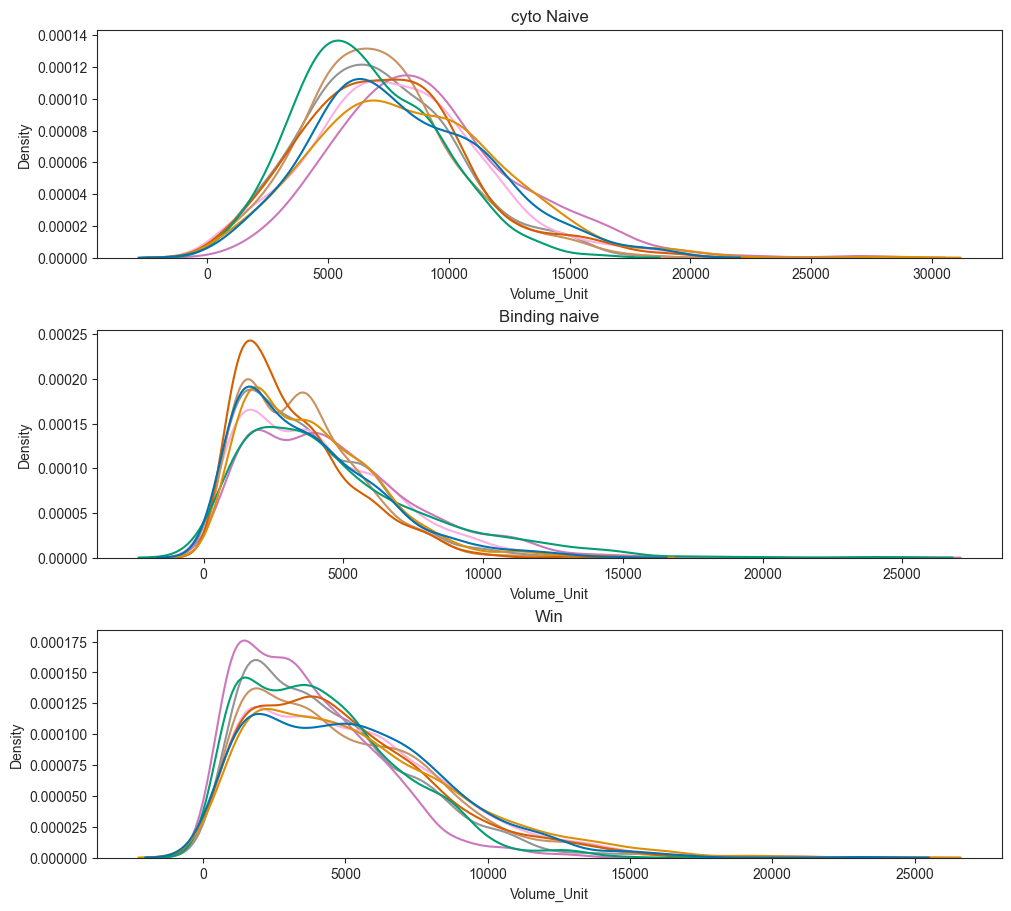

In [34]:
fig, ax = plt.subplots(3,1, figsize = (10,9), constrained_layout=True)
cyto =  df[df['max_intensity']>150]
binding = df[df['max_intensity']<=150]
sns.kdeplot(data = cyto[cyto['Condition']=='Naive'], x="Volume_Unit", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[0])
ax[0].set_title('cyto Naive')
sns.kdeplot(data = binding[binding['Condition']=='Naive'], x="Volume_Unit", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[1])
ax[1].set_title('Binding naive')
sns.kdeplot(data = df[df['Condition']=='SRWin'], x="Volume_Unit", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[2])
ax[2].set_title('Win')

(0.0, 10000.0)

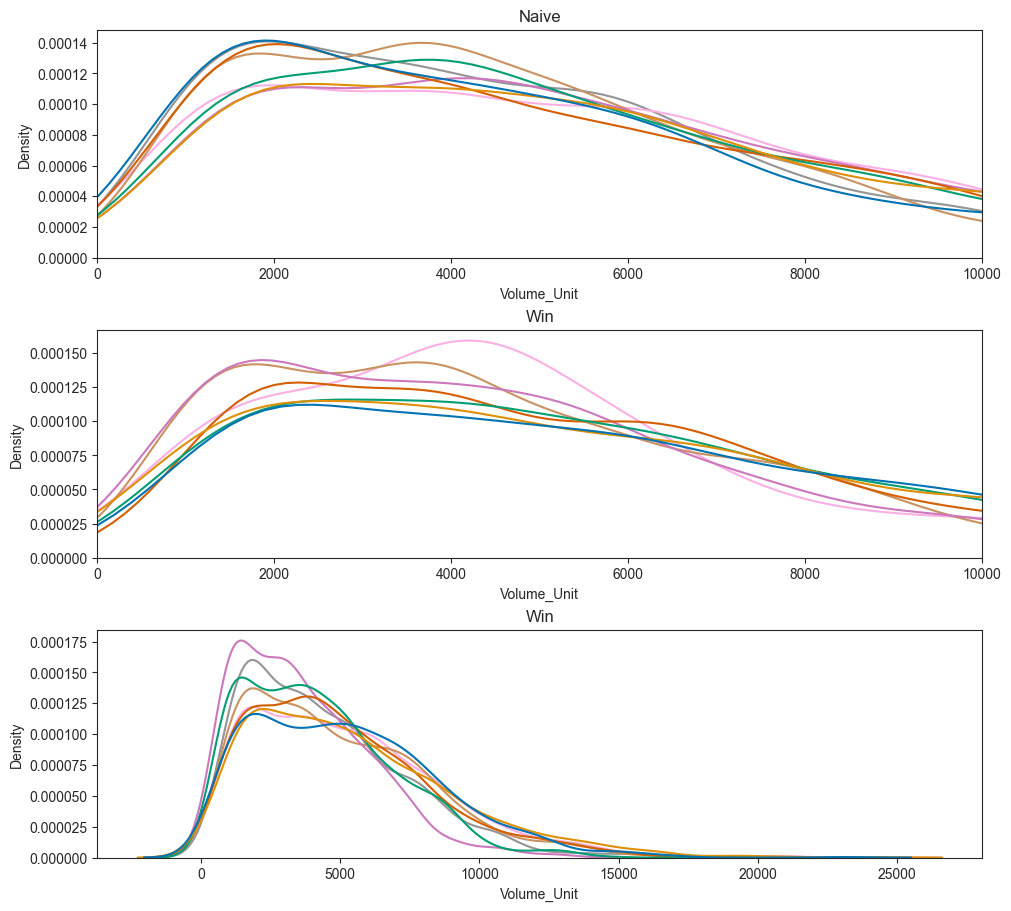

In [38]:
fig, ax = plt.subplots(3,1, figsize = (10,9), constrained_layout=True)
sns.kdeplot(data = df[df['Condition']=='Naive'], x="Volume_Unit", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[0])
ax[0].set_title('Naive')
sns.kdeplot(data = df[df['Condition']=='Win'], x="Volume_Unit", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[1])
ax[1].set_title('Win')
sns.kdeplot(data = df[df['Condition']=='SRWin'], x="Volume_Unit", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[2])
ax[2].set_title('Win')
ax[0].set_xlim(0, 10000)
ax[1].set_xlim(0, 10000)

Text(0.5, 1.0, 'Win')

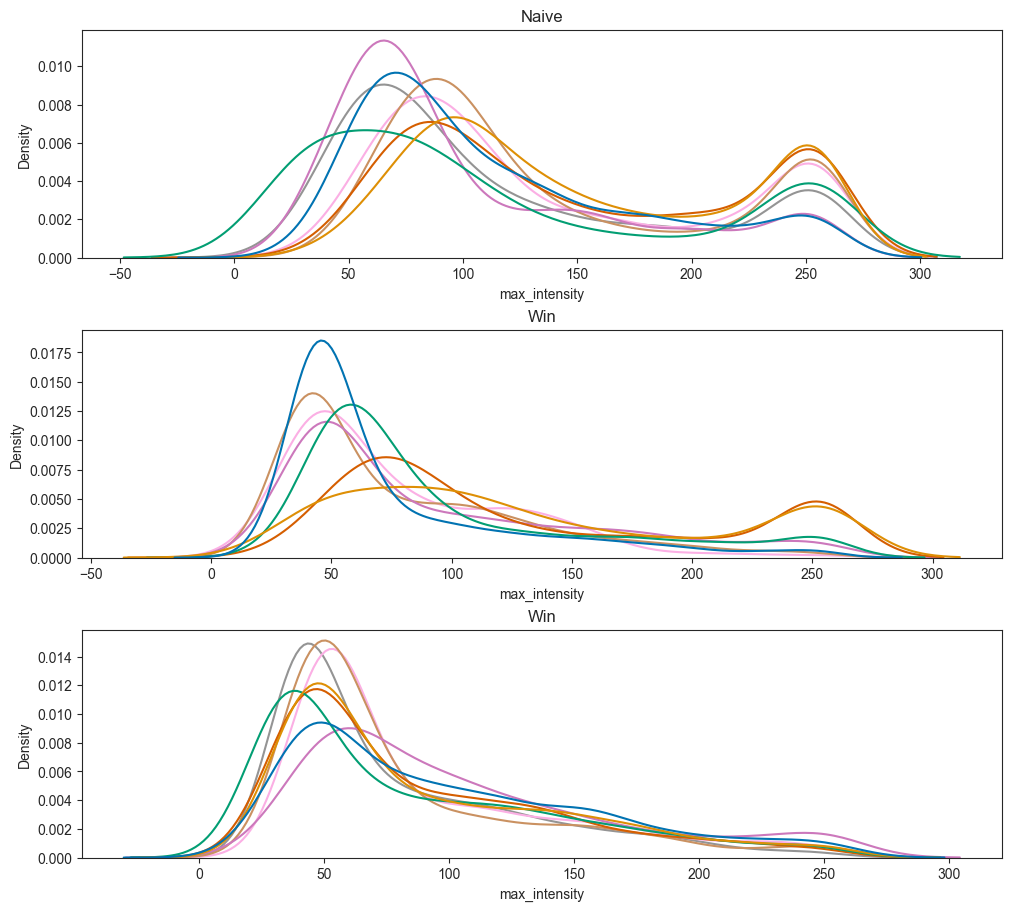

In [31]:
fig, ax = plt.subplots(3,1, figsize = (10,9), constrained_layout=True)
sns.kdeplot(data = df[df['Condition']=='Naive'], x="max_intensity", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[0])
ax[0].set_title('Naive')
sns.kdeplot(data = df[df['Condition']=='Win'], x="max_intensity", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[1])
ax[1].set_title('Win')
sns.kdeplot(data = df[df['Condition']=='SRWin'], x="max_intensity", hue="ID", common_norm=False, palette='colorblind', legend=False, ax = ax[2])
ax[2].set_title('Win')

## Plots

### Panel 1

C:\Windows\Temp\ipykernel_6340\3573560451.py:169: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = data,


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=7.992e-03 U_stat=4.400e+01
Win v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=2.824e-01 U_stat=3.300e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=1.554e-04 U_stat=6.400e+01


C:\Windows\Temp\ipykernel_6340\3573560451.py:169: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = data,


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=9.551e-01 U_stat=2.900e+01
Win v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=1.520e-01 U_stat=4.100e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=2.345e-01 U_stat=4.400e+01


C:\Windows\Temp\ipykernel_6340\3573560451.py:169: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = data,


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=2.051e-02 U_stat=4.800e+01
Win v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=1.000e+00 U_stat=2.800e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=3.108e-04 U_stat=6.300e+01


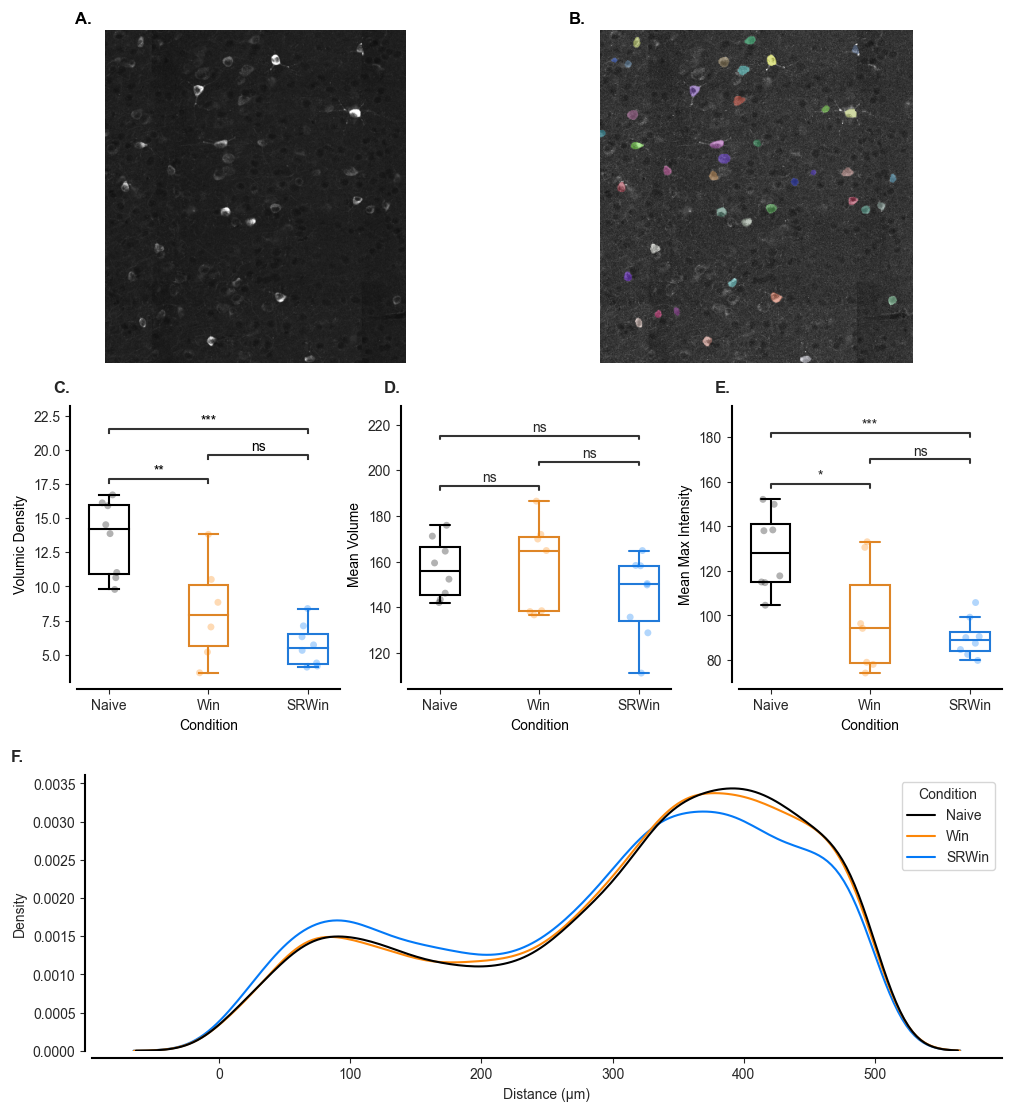

In [3]:
img = np.asarray(Image.open(r'C:\Users\Thenzing\Julien\TAPAS-Thomas\19326_B2_Mouse4_Veh_P36_M_C57_Rln_PFC1_FIG14_L.czi-1.tif'))
mask = np.asarray(Image.open(r'C:\Users\Thenzing\Julien\TAPAS-Thomas\19326_B2_Mouse4_Veh_P36_M_C57_Rln_PFC1_FIG14_L.czi-1_cp_masks.png'))

fig = plt.figure(constrained_layout=True, figsize=(10, 11))



(row1, row2, row3) = fig.subfigures(3, 1)


left, right = row1.subplots(1, 2)

left.set_axis_off()
left.imshow(img)
letter_annotation(left, -0.1, 1.02, 'A.')

right.set_axis_off()
right.imshow(mask)
letter_annotation(right, -0.1, 1.02, 'B.')


(mid1, mid2, mid3) = row2.subplots(1, 3)


custom_boxplot(data = mean_density, x = 'Condition', y = 'volumic_density_total', ax=mid1, letter = 'C.', xlabel = 'Condition', ylabel='Volumic Density' )

custom_boxplot(data = mean_animal, x = 'Condition', y = 'Volume_Unit', ax = mid2, letter = 'D.', xlabel = 'Condition', ylabel='Mean Volume')

custom_boxplot(data = mean_animal, x = 'Condition', y = 'max_intensity', ax = mid3, letter = 'E.', xlabel = 'Condition', ylabel='Mean Max Intensity')

sns.despine(offset=5, trim=False)



ax = row3.subplots(1, 1)
sns.kdeplot(data = df, x="distUnit", hue="Condition", common_norm=False, palette=sns.color_palette(), ax= ax).set(xlabel = "Distance (µm)")
letter_annotation(ax, -0.09, 1.05, 'F.')
sns.despine(offset=5, trim=False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
sns.set_style("ticks")

C:\Windows\Temp\ipykernel_10928\626909421.py:52: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot( data = mean_density, x = "Condition", y = "volumic_density_total", palette=sns.color_palette(), alpha = 0.7, ax=ax)
C:\Windows\Temp\ipykernel_10928\626909421.py:87: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=mean_animal, x = "Condition", y = "Volume_Unit", palette=sns.color_palette(), alpha = 0.7, ax=ax)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=2.051e-02 U_stat=4.800e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=3.108e-04 U_stat=6.300e+01


C:\Windows\Temp\ipykernel_10928\626909421.py:124: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=mean_animal, x = "Condition", y = "max_intensity", palette=sns.color_palette(), alpha = 1, ax=ax)


[Text(0.5, 0, 'Distance (µm)')]

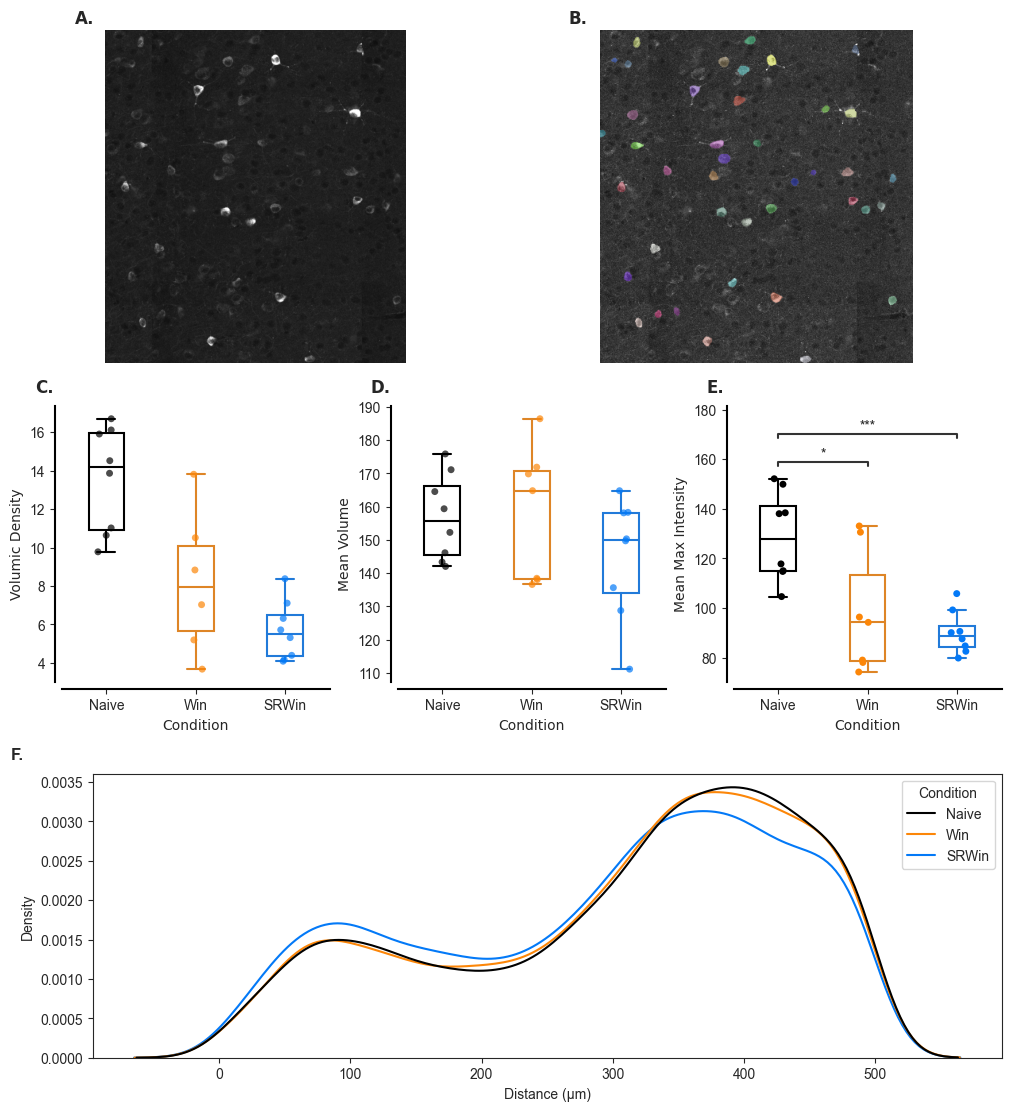

In [75]:
img = np.asarray(Image.open(r'C:\Users\Thenzing\Julien\TAPAS-Thomas\19326_B2_Mouse4_Veh_P36_M_C57_Rln_PFC1_FIG14_L.czi-1.tif'))
mask = np.asarray(Image.open(r'C:\Users\Thenzing\Julien\TAPAS-Thomas\19326_B2_Mouse4_Veh_P36_M_C57_Rln_PFC1_FIG14_L.czi-1_cp_masks.png'))

fig = plt.figure(constrained_layout=True, figsize=(10, 11))



(row1, row2, row3) = fig.subfigures(3, 1)
left, right = row1.subplots(1, 2)



left.set_axis_off()
left.imshow(img)
letter_annotation(left, -0.1, 1.02, 'A.')
left.set(xlabel='Raw image')
right.set_axis_off()
right.imshow(mask)
letter_annotation(right, -0.1, 1.02, 'B.')
left.set(xlabel='Segmented image')

(mid1, mid2, mid3) = row2.subplots(1, 3)
plt.rcParams['font.family'] = 'DejaVu Sans'
ax = mid1
letter_annotation(mid1, -0.1, 1.05, 'C.')
letter_annotation(mid2, -0.1, 1.05, 'D.')
letter_annotation(mid3, -0.1, 1.05, 'E.')



plot_med1 = sns.boxplot(data = mean_density, x = 'Condition', y = 'volumic_density_total', showfliers = False, width=0.4, ax = ax, palette=customPalette)
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches

for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers


sns.stripplot( data = mean_density, x = "Condition", y = "volumic_density_total", palette=sns.color_palette(), alpha = 0.7, ax=ax)
ax.set(ylabel = "Volumic Density")
sns.despine(offset=5, trim=False)
ax.grid(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
sns.set_style("ticks")


ax = mid2


plot_med1 = sns.boxplot(data = mean_animal, x = 'Condition', y = 'Volume_Unit', showfliers = False, width=0.4, ax = ax, palette=customPalette)
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers


sns.stripplot(data=mean_animal, x = "Condition", y = "Volume_Unit", palette=sns.color_palette(), alpha = 0.7, ax=ax)
ax.set(ylabel = "Mean Volume")
sns.despine(offset=5, trim=False)
ax.grid(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
sns.set_style("ticks")

ax = mid3

plot_med1 = sns.boxplot(data = mean_animal, x = 'Condition', y = 'max_intensity', showfliers = False, width=0.4, ax = ax, palette=customPalette)
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers
boxp =[("Naive", "Win"), ("SRWin", "Naive")]
add_stat_annotation(plot_med1, data=mean_animal, x="Condition", y='max_intensity', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
sns.stripplot(data=mean_animal, x = "Condition", y = "max_intensity", palette=sns.color_palette(), alpha = 1, ax=ax)
ax.set(ylabel = "Mean Max Intensity")
sns.despine(offset=5, trim=False)
ax.grid(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
sns.set_style("ticks")

ax = row3.subplots(1, 1)
letter_annotation(ax, -0.09, 1.05, 'F.')
sns.kdeplot(data = df, x="distUnit", hue="Condition", common_norm=False, palette=sns.color_palette(), ax= ax).set(xlabel = "Distance (µm)")

### Panel 2

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(11, 6))

colors = ['#000000','#FC8608','#0379F7']
customPalette = sns.set_palette(sns.color_palette(colors))

(row1, row2) = fig.subfigures(2, 1)
left, mid, right = row1.subplots(1, 3)
boxp =[("Naive", "Win"), ("SRWin", "Naive")]
plt.suptitle('Volumic density', fontsize = 20)
ax = left

C:\Windows\Temp\ipykernel_10928\862977786.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=mean_density, x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=2.930e-02 U_stat=4.100e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=1.554e-04 U_stat=6.400e+01


C:\Windows\Temp\ipykernel_10928\862977786.py:44: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=mean_density,x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=2.890e-02 U_stat=4.700e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=6.216e-04 U_stat=6.200e+01


C:\Windows\Temp\ipykernel_10928\862977786.py:77: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=mean_density,x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=3.730e-03 U_stat=5.200e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=1.554e-04 U_stat=6.400e+01


C:\Windows\Temp\ipykernel_10928\862977786.py:112: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=2.165e-03 U_stat=3.600e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=6.660e-04 U_stat=4.800e+01


C:\Windows\Temp\ipykernel_10928\862977786.py:146: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=2.214e-02 U_stat=3.700e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=2.176e-03 U_stat=5.300e+01


C:\Windows\Temp\ipykernel_10928\862977786.py:180: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=3.543e-01 U_stat=2.700e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=6.993e-03 U_stat=5.700e+01


C:\Windows\Temp\ipykernel_10928\862977786.py:214: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=4.908e-01 U_stat=3.000e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=1.476e-02 U_stat=5.500e+01


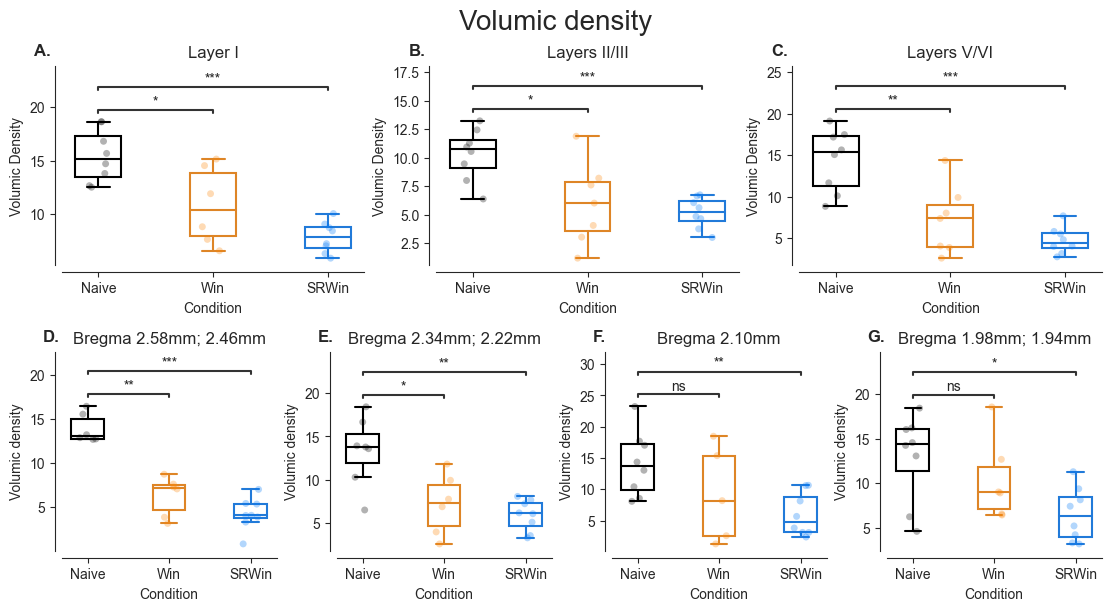

In [103]:
fig = plt.figure(constrained_layout=True, figsize=(11, 6))

colors = ['#000000','#FC8608','#0379F7']
customPalette = sns.set_palette(sns.color_palette(colors))

(row1, row2) = fig.subfigures(2, 1)
left, mid, right = row1.subplots(1, 3)
boxp =[("Naive", "Win"), ("SRWin", "Naive")]
plt.suptitle('Volumic density', fontsize = 20)
ax = left
plot_med1 = sns.boxplot(data=mean_density, y='volumic_density_layer1', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(data=mean_density, x = "Condition",
              y = "volumic_density_layer1",
              palette=sns.color_palette(),
              alpha = 0.3,
              ax=ax)
ax.set(title = 'Layer I', ylabel='Volumic Density')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers
add_stat_annotation(plot_med1, data=mean_density, x="Condition", y='volumic_density_layer1', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'A.')

ax = mid
plot_med1 = sns.boxplot(data=mean_density, y='volumic_density_layer23', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(data=mean_density,x = "Condition",
              y = "volumic_density_layer23",
              palette=sns.color_palette(),
              alpha = 0.3,
              ax=ax)
ax.set(title='Layers II/III', ylabel='Volumic Density')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers
add_stat_annotation(plot_med1, data=mean_density, x="Condition", y='volumic_density_layer23', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'B.')


ax = right
plot_med1 = sns.boxplot(data=mean_density, y='volumic_density_layer56', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(data=mean_density,x = "Condition",
              y = "volumic_density_layer56",
              palette=sns.color_palette(),
              alpha = 0.3,
              ax=ax)
ax.set(title='Layers V/VI', ylabel='Volumic Density')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers
add_stat_annotation(plot_med1, data=mean_density, x="Condition", y='volumic_density_layer56', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'C.')


left, mid1, mid2, right = row2.subplots(1, 4)
ax=left

plot_med1 = sns.boxplot(fig910, y='volumic_density_total', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              palette=sns.color_palette(),
              alpha = 0.3,
              data = fig910,
              ax=ax)
ax.set(title = 'Bregma 2.58mm; 2.46mm', ylabel = 'Volumic density')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers
add_stat_annotation(plot_med1, data=fig910, x="Condition", y='volumic_density_total', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'D.')


ax = mid1
plot_med1 = sns.boxplot(fig1112, y='volumic_density_total', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              palette=sns.color_palette(),
              alpha = 0.3,
              data = fig1112,
              ax=ax)
ax.set(title = 'Bregma 2.34mm; 2.22mm', ylabel = 'Volumic density')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers
add_stat_annotation(plot_med1, data=fig1112, x="Condition", y='volumic_density_total', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'E.')


ax = mid2
plot_med1 = sns.boxplot(fig13, y='volumic_density_total', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              palette=sns.color_palette(),
              alpha = 0.3,
              data = fig13,
              ax=ax)
ax.set(title = 'Bregma 2.10mm', ylabel = 'Volumic density')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers
add_stat_annotation(plot_med1, data=fig13, x="Condition", y='volumic_density_total', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'F.')


ax = right
plot_med1 = sns.boxplot(fig1415, y='volumic_density_total', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(x = "Condition",
              y = "volumic_density_total",
              palette=sns.color_palette(),
              alpha = 0.3,
              data = fig1415,
              ax=ax)
ax.set(title = 'Bregma 1.98mm; 1.94mm', ylabel = 'Volumic density')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

add_stat_annotation(plot_med1, data=fig1415, x="Condition", y='volumic_density_total', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'G.')





sns.despine(offset=5, trim=False)



### Panel 3 

C:\Windows\Temp\ipykernel_10928\1774668165.py:27: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x = "Condition",


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Naive v.s. Win: Mann-Whitney-Wilcoxon test two-sided, P_val=4.009e-02 U_stat=4.600e+01
Naive v.s. SRWin: Mann-Whitney-Wilcoxon test two-sided, P_val=1.554e-04 U_stat=6.400e+01


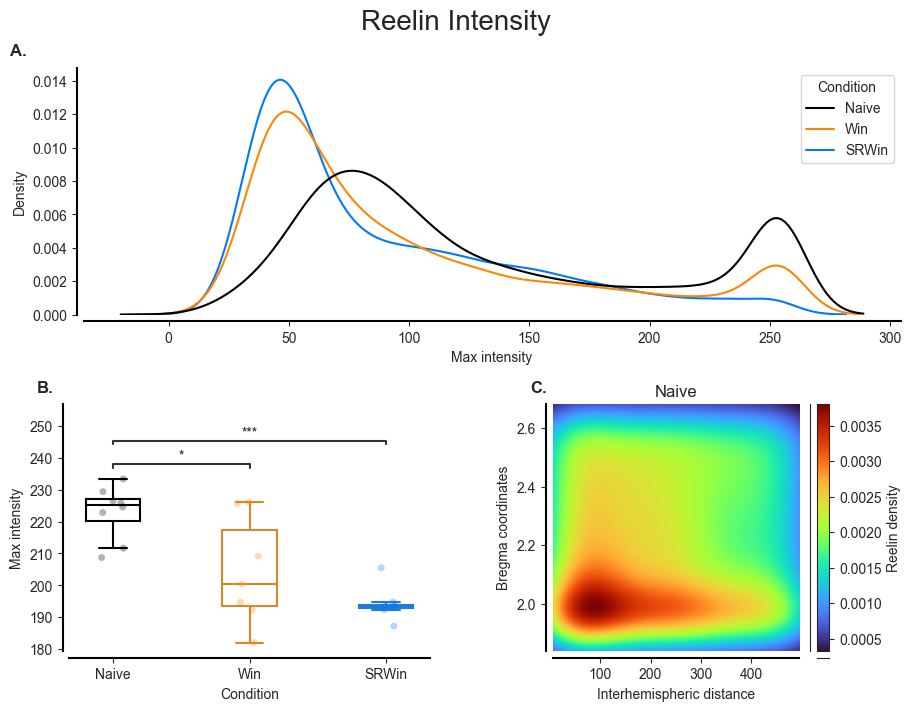

In [102]:
fig = plt.figure(constrained_layout=True, figsize=(9, 7))
fig.suptitle('Reelin Intensity', fontsize = 20)
colors = ['#000000','#FC8608','#0379F7']
customPalette = sns.set_palette(sns.color_palette(colors))

colors = ['#000000','#FC8608','#0379F7']
customPalette = sns.set_palette(sns.color_palette(colors))

(row1, row2) = fig.subfigures(2, 1)

ax = row1.subplots(1,1)
sns.kdeplot(data = df, x="max_intensity", hue="Condition", palette = customPalette, common_norm=False, ax = ax).set(xlabel = "Max intensity")
letter_annotation(ax, -0.09, 1.05, 'A.')

left, right = row2.subplots(1, 2)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
sns.set_style("ticks")


ax = left

plot_med1 = sns.boxplot(cyto, y='max_intensity', x = 'Condition', ax=ax, showfliers = False, width=0.4, palette=customPalette)
sns.stripplot(x = "Condition",
              y = "max_intensity",
              palette=sns.color_palette(),
              alpha = 0.3,
              data = cyto,
              ax=ax)
ax.set( ylabel = 'Max intensity')
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

boxp =[("Naive", "Win"), ("SRWin", "Naive")]
add_stat_annotation(plot_med1, data=cyto, x="Condition", y='max_intensity', comparisons_correction = None,

                    box_pairs=boxp,

                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
letter_annotation(ax, -0.09, 1.05, 'B.')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
sns.set_style("ticks")

ax = right
momi = minibin[minibin['Condition']=='Naive']
X = momi['bins2'].tolist()
Y = momi['Bregma_coord'].tolist()
Z = momi['max_intensity'].tolist()
scaled_Z = [z * 100000 for z in Z]
x = np.array(X)
y = np.array(Y)
z = np.array(Z)
ax.set_box_aspect(1)
offset = .1
xmin = x.min()-offset
xmax = x.max()+offset
ymin = y.min()-offset
ymax = y.max()+offset
ax.set(title='Naive')
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])
kernel = sps.gaussian_kde(values, weights=z)
Z = np.reshape(kernel(positions).T, X.shape)
ax.set(xlabel = 'Interhemispheric distance', ylabel='Bregma coordinates' )
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
img = ax.imshow(np.rot90(Z), cmap=plt.cm.turbo,
                extent=[xmin, xmax, ymin, ymax],
                aspect='auto')
cbar = fig.colorbar(img, ax=ax)
cbar.set_label('Reelin density')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
letter_annotation(ax, -0.09, 1.05, 'C.')


sns.despine(offset=5, trim=False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
sns.set_style("ticks")

In [238]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go

mo = df[df['ID']=='B4PPGI2Naive']

# Create a scatter plot trace
trace = go.Scatter3d(
    x=mo['Cx_Pix'],
    y=mo['Cy_Pix'],
    z=mo['Cz_Pix'],
    mode='markers',
    marker=dict(
        size=8,
        color=mo['max_intensity'],                # Set color to intensity
        colorscale='Viridis',                 # Choose a colorscale
        opacity=0.8
    )
)

# Create layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Plot the figure in Jupyter Notebook
fig.show()
